# Quantization

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import pyvww
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

training_set = pyvww.pytorch.VisualWakeWordsClassification(
    root="./visualwakewords/path-to-COCO-dataset/train2014",
    annFile="./visualwakewords/new-path-to-visualwakewords-dataset/annotations/instances_train.json",
    transform=transform
)

validation_set = pyvww.pytorch.VisualWakeWordsClassification(
    root="./visualwakewords/path-to-COCO-dataset/train2014",
    annFile="./visualwakewords/new-path-to-visualwakewords-dataset/annotations/instances_val.json",
    transform=transform
)



training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

loading annotations into memory...
Done (t=3.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


### Post Training Dynamic Quantization

In [19]:
import os

def ptdq(model, weights, save_path):

    device = torch.device('cuda')
    device_cpu = torch.device('cpu')

    state_dict = torch.load(weights, map_location=torch.device('cuda'))

    model.load_state_dict(state_dict)

    model_dynamic_quantized = torch.quantization.quantize_dynamic(
        model, 
        qconfig_spec={torch.nn.Linear, torch.nn.LSTM, torch.nn.GRU, torch.nn.RNN}, 
        dtype=torch.qint8
    )

    torch.save(model_dynamic_quantized, save_path)

    model.eval()

    model.to(device)

    print("Model loaded successfully")

    val_correct=0
    for batch_idx, (vinputs, vlabels) in enumerate(validation_loader):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)

        voutputs = model(vinputs)

        _, vpreds = torch.max(voutputs, 1)
        val_correct += (vpreds == vlabels).sum().item()
        
    print(f'Non Quantized Model Accuracy: {val_correct/(64*len(validation_loader))}')

    model_dynamic_quantized.eval()

    val_correct = 0
    for batch_idx, (vinputs, vlabels) in enumerate(validation_loader):
        vinputs, vlabels = vinputs.to(device_cpu), vlabels.to(device_cpu)  # Move to CPU
        voutputs = model_dynamic_quantized(vinputs)
        _, vpreds = torch.max(voutputs, 1)
        val_correct += (vpreds == vlabels).sum().item()

        
    print(f'Quantized Model Accuracy: {val_correct/(64*len(validation_loader))}')
    
    torch.save(model, './dummy.ph')
    # Compare model sizes
    original_size = os.path.getsize('./dummy.ph') / (1024 * 1024)  # Convert bytes to MB
    quantized_size = os.path.getsize(save_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove('./dummy.ph')
    print(f'Original Model Size: {original_size:.2fhttps://github.com/ManosXen/embedded_computer_vision.git} MB')
    print(f'Quantized Model Size: {quantized_size:.2f} MB')


##### Shufflenet x0_5

In [20]:
import torch
import torchvision.models as models

model = models.shufflenet_v2_x0_5(weights=None)
model.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

ptdq(model, "./models/full_models/shufflenet_v2_x0_5.pth", "./models/quantized_models/dynamic/shufflenet_v2_x0_5.pth")

Model loaded successfully
Non Quantized Model Accuracy: 0.8204365079365079
Quantized Model Accuracy: 0.8198164682539683
Original Model Size: 1.47 MB
Quantized Model Size: 1.48 MB


##### Shufflenet x1_0

In [21]:
import torch
import torchvision.models as modelshttps://github.com/ManosXen/embedded_computer_vision.git

device_cpu = torch.device('cpu')

model = models.shufflenet_v2_x1_0(weights=None)
model.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

ptdq(model, "./models/full_models/shufflenet_v2_x1_0.pth", "./models/quantized_models/dynamic/shufflenet_v2_x1_0.pth")

Model loaded successfully
Non Quantized Model Accuracy: 0.8420138888888888
Quantized Model Accuracy: 0.8421378968253969
Original Model Size: 4.98 MB
Quantized Model Size: 4.98 MB


##### SqueezeNet 1.1

Δεν υποστηρίζει όλα τα layers πέρα από:
* torch.nn.Linear
* torch.nn.LSTM
* torch.nn.GRU
* torch.nn.RNN (limited)

οπότε δεν κάνει quantization για το squeezenet


Για το dynamic quantization οι επιλογές για dtype είναι qint8, quint8, qint32, float16

### Post Training Static Quantization

In [4]:
from torch.utils.data import Subset

subset_indices = list(range(150))
subset = Subset(training_loader.dataset, subset_indices)
observation_loader = torch.utils.data.DataLoader(subset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)



In [10]:
import copy

def ptsq(model, weights, save_path):

    device = torch.device('cuda')
    device_cpu = torch.device('cpu')

    backend = "fbgemm" #x86

    state_dict = torch.load(weights, map_location=torch.device('cuda'))
    model.load_state_dict(state_dict)

    m = copy.deepcopy(model)

    quantized_model = nn.Sequential(torch.quantization.QuantStub(), 
                  m, 
                  torch.quantization.DeQuantStub())

    quantized_model.qconfig = torch.quantization.get_default_qconfig(backend)
    torch.quantization.prepare(quantized_model, inplace=True)

    for vinputs, vlabels in observation_loader:
            vinputs, vlabels = vinputs.to(device_cpu), vlabels.to(device_cpu)  # Move to CPU
            quantized_model(vinputs)
    
    torch.quantization.convert(quantized_model, inplace=True)
    
    torch.save(quantized_model.state_dict(), save_path)
    torch.save(model.state_dict(), './dummy.pt')
    # Compare model sizes
    original_size = os.path.getsize('./dummy.pt') / (1024 * 1024)  # Convert bytes to MB
    quantized_size = os.path.getsize(save_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove('./dummy.pt')
    print(f'Original Model Size: {original_size:.2f} MB')
    print(f'Quantized Model Size: {quantized_size:.2f} MB')
    
    model.to(device)
    model.eval()

    val_correct=0
    start_time=time.time()
    for batch_idx, (vinputs, vlabels) in enumerate(validation_loader):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)

        voutputs = model(vinputs)

        _, vpreds = torch.max(voutputs, 1)
        val_correct += (vpreds == vlabels).sum().item()
    end_time=time.time()
    execution_time=end_time-start_time    
    print(f'Non Quantized Model Accuracy: {val_correct/(64*len(validation_loader)):.3f}')
    print(f'Execution Time of Non Quantized Models when running on GPU {execution_time:.3f} sec')
    print(f'FPS Non Quantized on GPU: {(64*len(validation_loader)/execution_time):.3f}')

    torch.quantization.convert(quantized_model, inplace=True)
    quantized_model.eval()

    val_correct = 0
    start_time=time.time()
    for batch_idx, (vinputs, vlabels) in enumerate(validation_loader):
        vinputs, vlabels = vinputs.to(device_cpu), vlabels.to(device_cpu)  # Move to CPU
        voutputs = quantized_model(vinputs)
        _, vpreds = torch.max(voutputs, 1)
        val_correct += (vpreds == vlabels).sum().item()
    end_time=time.time()
    execution_time=end_time-start_time
        
    print(f'Quantized Model Accuracy: {val_correct/(64*len(validation_loader)):.3f}')
    print(f'Execution Time of Quantized Model CPU {execution_time:.3f} sec')
    print(f'FPS Quantized CPU: {(64*len(validation_loader))/execution_time:.3f}')



### ShuffleNet v2 x0_5

In [12]:
import torch
import torchvision.models as models

model = models.shufflenet_v2_x0_5(weights=None)
model.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

ptsq(model, "./models/full_models/shufflenet_v2_x0_5.pth", "./models/quantized_models/static/shufflenet_v2_x0_5.pt")

Original Model Size: 1.43 MB
Quantized Model Size: 0.65 MB
Non Quantized Model Accuracy: 0.820
Execution Time of Non Quantized Models when running on GPU 17.458 sec
FPS Non Quantized on GPU: 461.912


/home/manos-xenos/Documents/Ενσωμετωμένα Συστήματα Επεξεργασίας/bonus_project/lib/python3.12/site-packages/torchvision/models/shufflenetv2.py:97: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)
/home/manos-xenos/Documents/Ενσωμετωμένα Συστήματα Επεξεργασίας/bonus_project/lib/python3.12/site-packages/torchvision/models/shufflenetv2.py:95: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  out = torch.cat((x1, self.branch2(x2)), dim=1)


Quantized Model Accuracy: 0.806
Execution Time of Quantized Model CPU 29.871 sec
FPS Quantized CPU: 269.960


### ShuffleNet v2 x1_0

In [13]:
import torch
import torchvision.models as models

device_cpu = torch.device('cpu')

model = models.shufflenet_v2_x1_0(weights=None)
model.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True)

ptsq(model, "./models/full_models/shufflenet_v2_x1_0.pth", "./models/quantized_models/static/shufflenet_v2_x1_0.pt")

Original Model Size: 4.95 MB
Quantized Model Size: 1.63 MB
Non Quantized Model Accuracy: 0.842
Execution Time of Non Quantized Models when running on GPU 18.185 sec
FPS Non Quantized on GPU: 443.435
Quantized Model Accuracy: 0.828
Execution Time of Quantized Model CPU 198.493 sec
FPS Quantized CPU: 40.626


### SqueezeNet 1_1

In [14]:
import torch
import torchvision.models as models

device_cpu = torch.device('cpu')

model = models.squeezenet1_1(weights=None)
model.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))

ptsq(model, "./models/full_models/squeezenet1_1.pth", "./models/quantized_models/static/squeezenet1_1.pt")

Original Model Size: 2.77 MB
Quantized Model Size: 0.79 MB
Non Quantized Model Accuracy: 0.888
Execution Time of Non Quantized Models when running on GPU 17.278 sec
FPS Non Quantized on GPU: 466.728


/home/manos-xenos/Documents/Ενσωμετωμένα Συστήματα Επεξεργασίας/bonus_project/lib/python3.12/site-packages/torchvision/models/squeezenet.py:31: UserWarning: All inputs of this cat operator must share the same quantization parameters. Otherwise large numerical inaccuracies may occur. (Triggered internally at /pytorch/aten/src/ATen/native/quantized/cpu/TensorShape.cpp:168.)
  return torch.cat(


Quantized Model Accuracy: 0.854
Execution Time of Quantized Model CPU 49.923 sec
FPS Quantized CPU: 161.529


In [15]:
import torch
import torchvision.models as models

device_cpu = torch.device('cpu')

model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)

ptsq(model, "./models/full_models/resnet18.pth", "./models/quantized_models/static/resnet.pth")

Original Model Size: 42.71 MB
Quantized Model Size: 10.87 MB
Non Quantized Model Accuracy: 0.894
Execution Time of Non Quantized Models when running on GPU 18.583 sec
FPS Non Quantized on GPU: 433.956


NotImplementedError: Could not run 'aten::add.out' with arguments from the 'QuantizedCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::add.out' is only available for these backends: [CPU, CUDA, Meta, MkldnnCPU, SparseCPU, SparseCUDA, SparseMeta, SparseCsrCPU, SparseCsrCUDA, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA.cpp:44731 [kernel]
Meta: registered at /dev/null:488 [kernel]
MkldnnCPU: registered at /pytorch/build/aten/src/ATen/RegisterMkldnnCPU.cpp:535 [kernel]
SparseCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCPU.cpp:1407 [kernel]
SparseCUDA: registered at /pytorch/build/aten/src/ATen/RegisterSparseCUDA.cpp:1577 [kernel]
SparseMeta: registered at /pytorch/build/aten/src/ATen/RegisterSparseMeta.cpp:291 [kernel]
SparseCsrCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrCPU.cpp:1155 [kernel]
SparseCsrCUDA: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrCUDA.cpp:1291 [kernel]
SparseCsrMeta: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrMeta.cpp:1069 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:503 [backend fallback]
Functionalize: registered at /pytorch/build/aten/src/ATen/RegisterFunctionalization_0.cpp:23301 [kernel]
Named: fallthrough registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: registered at /pytorch/torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4942 [kernel]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:17801 [kernel]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:465 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:499 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]


In [ ]:
import torch
import torchvision.models as models

device_cpu = torch.device('cpu')

model = models.mobilenet_v3_small(weights=None)
num_features = model.classifier[-1].in_features  # Get input features of last FC layer
model.classifier[-1] = nn.Linear(num_features, 2)  # Change output to 2 classes

ptsq(model, "./models/full_models/mobilenet_v3_Small_freeze.pth", "./models/quantized_models/static/mobilenet_v3_Small_freeze.pth")

Original Model Size: 5.95 MB
Quantized Model Size: 1.86 MB
Non-Quantized Model Accuracy: 0.8779


RuntimeError: empty_strided not supported on quantized tensors yet see https://github.com/pytorch/pytorch/issues/74540

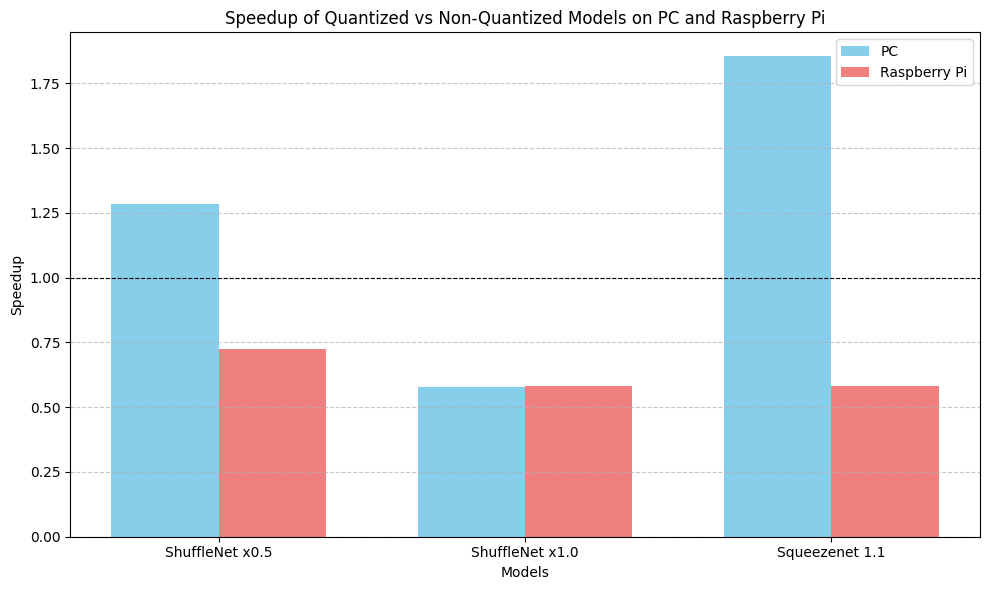

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
speedup_pc = [1.285, 0.579, 1.854]
speedup_rasberry = [0.725, 0.581, 0.583]
models = ["ShuffleNet x0.5", "ShuffleNet x1.0", "Squeezenet 1.1"]

# Set up the bar positions
x = np.arange(len(models))  # Creates positions [0, 1, 2]
bar_width = 0.35  # Width of each bar

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(x - bar_width/2, speedup_pc, bar_width, label='PC', color='skyblue')
plt.bar(x + bar_width/2, speedup_rasberry, bar_width, label='Raspberry Pi', color='lightcoral')

# Add a dashed line at speedup = 1
plt.axhline(y=1, color='black', linestyle='--', linewidth=0.8)

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Speedup')
plt.title('Speedup of Quantized vs Non-Quantized Models on PC and Raspberry Pi')
plt.xticks(x, models)  # Set model names on x-axis
plt.legend()  # Add a legend
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add a subtle grid

# Display the plot
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()